# SherLock

## Load Libraries

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

In [3]:
pd.set_option('display.max_columns', None)

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [4]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size', '[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [5]:
# Non-standard columns present, need function to fix
#filename = './archive/AllBroadcasts.csv'
#AllBroadcasts = pd.read_csv(filename)
#AllBroadcasts['UUID'] = AllBroadcasts['UUID'].apply(pd.to_datetime, unit='ms')

# Drop bad rows for now...
#alphabet_string = string.ascii_lowercase
#alphabet_list = list(alphabet_string)

#AllBroadcasts[AllBroadcasts['timestamp'].str().isin(alphabet_list)]

#indexID = AllBroadcasts[(AllBroadcasts['timestamp'] >= 21)].index
#AllBroadcasts.drop(indexID, inplace = True)


#AllBroadcasts.head(3)

In [6]:
#filename = './archive/AppPackages.csv'
#AppPackages = pd.read_csv(filename)    # Ending columns need to be appended into sherlock_version - make function!

#AppPackages[['UUID','InstallTime']] = AppPackages[['UUID', 'InstallTime']].apply(pd.to_datetime, unit='ms')
##AppPackages.drop([])
##AppPackages = AppPackages.set_index('UUID')
#print(AppPackages['UserId'].unique())
#AppPackages = AppPackages.drop(columns=['UserId'])
#print(AppPackages.shape)
##AppPackages.head(3)

In [7]:
# Raw TSV
filename = './anon_Bluetooth.tsv'
header_list = ['userid', 'uuid', 'bluetooth_appearance', 'bluetooth_class', 'bluetooth_maddress',
               'bluetooth_mremotebrsf', 'bluetooth_mvaluenrec', 'bluetooth_mvaluewbs', 'bluetooth_name',
               'bluetooth_rssi', 'bluetooth_timestamp']
Bluetooth_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['bluetooth_timestamp'])
Bluetooth_tsv['uuid'] = (pd.to_datetime(Bluetooth_tsv['uuid'], unit='ms'))      # Convert to datatime
Bluetooth_tsv = Bluetooth_tsv.sort_values(by='uuid')                            # Unsorted, so sorting required
Bluetooth_tsv = Bluetooth_tsv.drop(columns=['bluetooth_mremotebrsf',
                                            'bluetooth_mvaluenrec',
                                            'bluetooth_mvaluewbs']) # Nan's and singular values, depricated
print(Bluetooth_tsv.shape)
#Bluetooth_tsv.head(3)

(657342, 8)


In [8]:
# Kaggle CSV
#filename = './archive/Bluetooth.csv'
#Bluetooth = pd.read_csv(filename, parse_dates=['Bluetooth_timestamp'])
#Bluetooth = Bluetooth.rename(columns={"UserID": "UUID", "UUID": "UserID"})   # Header names swapped apparently
#Bluetooth['UUID'] = Bluetooth['UUID'].apply(pd.to_datetime, unit='ms')
#Bluetooth = Bluetooth.set_index('UUID')
#print(Bluetooth['UserID'].unique())
#Bluetooth = Bluetooth.drop(columns=['UserID'])
#print(Bluetooth.shape)
#Bluetooth.head(3)

In [9]:
#filename = './archive/Calls.csv'
#Calls = pd.read_csv(filename)
#Calls[['UUID','Date']] = Calls[['UUID',
#                                'Date']].apply(pd.to_datetime, unit='ms')
#Calls['FromContacts'] = Calls['FromContacts'].astype(int)                      # Original True/False
##Calls = Calls.set_index('UUID')
#print(Calls['UserId'].unique())
#Calls = Calls.drop(columns=['UserId'])
#print(Calls.shape)
##Calls.head(3)

In [10]:
# Raw TSV
filename = './Moriartyprobe.tsv'
header_list = ['userid', 'uuid', 'details', 'action', 'actionType', 'sessionType', 'version', 'sessionID', 'behavior']
Moriarty_tsv = pd.read_csv(filename, sep='\t', names=header_list)
Moriarty_tsv['uuid'] = (pd.to_datetime(Moriarty_tsv['uuid'], unit='ms'))     # Convert to datatime
Moriarty_tsv = Moriarty_tsv.sort_values(by='uuid')                           # Unsorted, so sorting required
#print(Moriarty_tsv['userid'].unique())
print(Moriarty_tsv.shape)
Moriarty_tsv.head(3)

(513981, 9)


,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior
494619,fe186dc437,2016-01-01 00:14:34.546,Application entered onCreate(),Application started,benign,benign,1.0,27,NaN
494625,fe186dc437,2016-01-01 00:14:34.701,User started to play a game (name);pearl,Game stared,benign,benign,1.0,27,NaN
494620,fe186dc437,2016-01-01 00:14:34.810,App entered onResume,App Mode change,benign,benign,1.0,27,NaN


In [11]:
# Feature cleaning: drop odd states
#print(Moriarty_tsv['actionType'].unique())
#print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'html'].shape)
#print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'javascript'].shape)
Moriarty_tsv = Moriarty_tsv.drop(Moriarty_tsv[(Moriarty_tsv['actionType'] == 'html') | 
                                              (Moriarty_tsv['actionType'] == 'javascript')].index)
# Feature cleaning: drop v from version
Moriarty_tsv['version'] = Moriarty_tsv['version'].astype(str).map(lambda x: x.lstrip('v'))

In [12]:
# Kaggle CSV
#filename = './archive/Moriarty.csv'
#editTextFile(filename)
#Moriarty = pd.read_csv('editTextFile.txt')
#Moriarty['UUID'] = (pd.to_datetime(Moriarty['UUID'], unit='ms'))
#Moriarty = Moriarty.set_index('UUID')
#print(Moriarty['UserId'].unique())
#Moriarty = Moriarty.drop(columns=['UserId'])
#print(Moriarty.shape)
#Moriarty.head(3)

In [13]:
# Raw TSV
filename = './Screenon.tsv'
header_list = ['userid', 'uuid', 'screenon', 'timestamp']
Screenon_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['timestamp'])
Screenon_tsv['uuid'] = (pd.to_datetime(Screenon_tsv['uuid'], unit='ms'))
Screenon_tsv = Screenon_tsv.sort_values(by='uuid')
Screenon_tsv['screenon'] = Screenon_tsv['screenon'].astype(int)                    # Original True:On / False:Off
#print(Screenon_tsv['userid'].unique())
print(Screenon_tsv.shape)
Screenon_tsv.head()

(617639, 4)


,userid,uuid,screenon,timestamp
136056,5b76bedcac,2016-01-01 00:01:59.446,1,2016-01-01 02:01:59.445
0,0a50e09262,2016-01-01 00:01:59.475,1,2016-01-01 02:01:59.474
170911,65f42fb278,2016-01-01 00:02:01.760,1,2016-01-01 02:02:01.759
136057,5b76bedcac,2016-01-01 00:02:21.323,0,2016-01-01 02:02:21.323
1,0a50e09262,2016-01-01 00:02:29.340,0,2016-01-01 02:02:29.340


In [14]:
## Kaggle CSV
#filename = './archive/ScreenOn.csv'
#ScreenOn = pd.read_csv(filename, parse_dates=['Timestamp'])
#ScreenOn['UUID'] = (pd.to_datetime(ScreenOn['UUID'], unit='ms'))
#ScreenOn['ScreenOn'] = ScreenOn['ScreenOn'].astype(int)                    # Original True/False
##ScreenOn = ScreenOn.set_index('UUID')
#print(ScreenOn['UserID'].unique())
#ScreenOn = ScreenOn.drop(columns=['UserID'])
#print(ScreenOn.shape)
##ScreenOn.head(3)

In [15]:
#filename = './archive/SMS.csv'
#SMS = pd.read_csv(filename)
#SMS[['UUID','Date']] = SMS[['UUID','Date']].apply(pd.to_datetime, unit='ms')
#SMS[['ContainsURL', 'FromContacts']] = SMS[['ContainsURL', 
#                                            'FromContacts']].astype(int)   # Original True/False
##SMS = SMS.set_index('UUID')
#print(SMS['UserId'].unique())
#SMS = SMS.drop(columns=['UserId'])
#print(SMS.shape)
##SMS.head(3)

In [16]:
#filename = './archive/T0.csv'
#T0 = pd.read_csv(filename, parse_dates=['Telephoney_timestemp', 
#                                        'SystemInfo_timestemp'])
#T0['UUID'] = (pd.to_datetime(T0['UUID'], unit='ms'))
##T0 = T0.set_index('UUID')
#print(T0['UserId'].unique())
#T0 = T0.drop(columns=['UserId'])
#print(T0.shape)
##T0.head(3)

In [17]:
# Raw TSV
filename = './a_anon_T1.tsv'
header_list = ['userid', 'uuid', 'version', 'googleplayloc_speed','googleplayloc_maccuracy',
               'googleplayloc_timestamp','celltower_cid','celltower_lac','celltower_psc',
               'celltower_timestamp','celltower_type','status_alarmvol','status_brightnessmode',
               'status_brightness_file','status_brightness_settings','status_dtmfvol','status_musicvol',
               'status_notificationvol','status_orientation','status_ringermode','status_ringtonevol',
               'status_systemvol','status_voicecallvol','status_timestamp',
               'location_spatio_5means','location_spatio_10means','location_spatio_25means',
               'location_spatio_50means','location_spatio_75means','location_spatio_100means',
               'location_spatioTemporal_day_5means','location_spatioTemporal_day_25means',
               'location_spatioTemporal_day_100means','location_spatioTemporal_week_5means',
               'location_spatioTemporal_week_25means','location_spatioTemporal_week_100means']
T1_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['googleplayloc_timestamp',
                                                                        'celltower_timestamp',
                                                                        'status_timestamp'])
T1_tsv['uuid'] = (pd.to_datetime(T1_tsv['uuid'], unit='ms'))
T1_tsv = T1_tsv.sort_values(by='uuid')
print(T1_tsv.shape)
T1_tsv.head(3)

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2697136, 36)


,userid,uuid,version,googleplayloc_speed,googleplayloc_maccuracy,googleplayloc_timestamp,celltower_cid,celltower_lac,celltower_psc,celltower_timestamp,celltower_type,status_alarmvol,status_brightnessmode,status_brightness_file,status_brightness_settings,status_dtmfvol,status_musicvol,status_notificationvol,status_orientation,status_ringermode,status_ringtonevol,status_systemvol,status_voicecallvol,status_timestamp,location_spatio_5means,location_spatio_10means,location_spatio_25means,location_spatio_50means,location_spatio_75means,location_spatio_100means,location_spatioTemporal_day_5means,location_spatioTemporal_day_25means,location_spatioTemporal_day_100means,location_spatioTemporal_week_5means,location_spatioTemporal_week_25means,location_spatioTemporal_week_100means
1243201,8ef449026a,2016-01-01 00:00:13.068000000,2.0,0.0,39.0,2016-01-01 02:00:02.205,6e6ed5bf6b41f5f,7e347f4c49a684c,bd10d7619b5800a,2016-01-01 02:00:00.180,1.0,11.0,Manual,0.0,20.0,15.0,6.0,15.0,Portrait,Normal,15.0,12.0,4.0,2016-01-01 02:00:00.168,5.0,2.0,1.0,25.0,70.0,78.0,3.0,4.0,25.0,1.0,7.0,53.0
1530201,9f7c0cf3ba,2016-01-01 00:00:13.704000000,2.0,0.0,34.5,2016-01-01 02:00:02.717,af02e3b2c73b03f,a7d0f5ff55a6956,0fe710c81ab2c69,2016-01-01 02:00:00.810,1.0,11.0,Auto,0.0,134.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-01-01 02:00:00.889,2.0,2.0,1.0,34.0,56.0,81.0,3.0,9.0,60.0,1.0,10.0,75.0
2144995,dd25a68e9e,2016-01-01 00:00:13.838000128,2.0,0.0,40.5,2016-01-01 01:59:36.848,90c38b44e42dfce,2c482b578dd5ef9,6bd33b4b0e8172b,2016-01-01 01:59:33.820,1.0,11.0,Manual,0.0,101.0,0.0,15.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-01-01 01:59:33.825,3.0,5.0,9.0,50.0,14.0,21.0,5.0,2.0,40.0,5.0,8.0,96.0


In [18]:
## CSV
#filename = './archive/T1.csv'
#T1 = pd.read_csv(filename, parse_dates=['GooglePlayLoc_timestamp', 
#                                        'CellTower_timestamp', 
#                                        'Status_timestamp'])
#T1['UUID'] = (pd.to_datetime(T1['UUID'], unit='ms'))
##T1 = T1.set_index('UUID')
#print(T1['UserID'].unique())
#T1 = T1.drop(columns=['UserID'])
#print(T1.shape)
##T1.head(3)

In [19]:
#filename = './archive/T2.csv'
#T2 = pd.read_csv(filename, parse_dates=['TimeStemp'], low_memory=False)
#T2['UUID'] = (pd.to_datetime(T2['UUID'], unit='ms'))
##T2 = T2.set_index('UUID')
#print(T2['UserID'].unique())
#T2 = T2.drop(columns=['UserID'])
#print(T2.shape)
##T2.head(3)

In [20]:
#filename = './archive/T3.csv'
#T3 = pd.read_csv(filename, parse_dates=['Audio_timestemp', 
#                                        'Light_timestamp'], low_memory=False)
#T3['UUID'] = (pd.to_datetime(T3['UUID'], unit='ms'))
##T3 = T3.set_index('UUID')
##print(T3['Userid'].unique())
#T3 = T3.drop(columns=['Userid'])
#print(T3.shape)
#T3.head(3)

In [21]:
# Raw TSV
filename = './T4_filtered.tsv'
header_list = ['userid','uuid','version','CpuHertz','CPU_0','CPU_1','CPU_2','CPU_3','Total_CPU',
               'TotalMemory_freeSize','TotalMemory_max_size','TotalMemory_total_size','TotalMemory_used_size',
               'Traffic_MobileRxBytes','Traffic_MobileRxPackets','Traffic_MobileTxBytes',
               'Traffic_MobileTxPackets','Traffic_TotalRxBytes','Traffic_TotalRxPackets','Traffic_TotalTxBytes',
               'Traffic_TotalTxPackets','Traffic_TotalWifiRxBytes','Traffic_TotalWifiRxPackets',
               'Traffic_TotalWifiTxBytes','Traffic_TotalWifiTxPackets','Traffic_timestamp','Battery_charge_type',
               'Battery_current_avg','Battery_health','Battery_icon_small','Battery_invalid_charger',
               'Battery_level','Battery_online','Battery_plugged','Battery_present','Battery_scale',
               'Battery_status','Battery_technology','Battery_temperature','Battery_timestamp','Battery_voltage',
               'MemTotal','MemFree','Buffers','Cached','SwapCached','Active','Inactive','Active_anon',
               'Inactive_anon','Active_file','Inactive_file','Unevictable','Mlocked','HighTotal','HighFree',
               'LowTotal','LowFree','SwapTotal','SwapFree','Dirty','Writeback','AnonPages','Mapped',
               'Shmem','Slab','SReclaimable','SUnreclaim','KernelStack','PageTables','CommitLimit','Committed_AS',
               'VmallocTotal','VmallocUsed','VmallocChunk','msmgpio_cpu0','msmgpio_sum_cpu123','wcd9xxx_cpu0',
               'wcd9xxx_sum_cpu123','pn547_cpu0','pn547_sum_cpu123','cypress_touchkey_cpu0',
               'cypress_touchkey_sum_cpu123','synaptics_rmi4_i2c_cpu0','synaptics_rmi4_i2c_sum_cpu123',
               'sec_headset_detect_cpu0','sec_headset_detect_sum_cpu123','flip_cover_cpu0','flip_cover_sum_cpu123',
               'home_key_cpu0','home_key_sum_cpu123','volume_down_cpu0','volume_down_sum_cpu123','volume_up_cpu0',
               'volume_up_sum_cpu123','companion_cpu0','companion_sum_cpu123','SLIMBUS_cpu0','SLIMBUS_sum_cpu123',
               'function_call_interrupts_cpu0','function_call_interrupts_sum_cpu123','cpu123_intr_prs','tot_user',
               'tot_nice','tot_system','tot_idle','tot_iowait','tot_irq','tot_softirq','ctxt','btime','processes',
               'procs_running','procs_blocked','connectedWifi_SSID','connectedWifi_Level', '117','118','119',
              '120', '121','122','123','124','125','126','127','128','129','130']
T4_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['Traffic_timestamp'])
T4_tsv['uuid'] = (pd.to_datetime(T4_tsv['uuid'], unit='ms'))
T4_tsv = T4_tsv.drop(columns=['Battery_charge_type','Battery_current_avg','Battery_health','Battery_icon_small',
                              'Battery_invalid_charger','Battery_level','Battery_online','Battery_plugged',
                              'Battery_present','Battery_scale','Battery_status','Battery_technology',
                              'Battery_temperature','Battery_timestamp','Battery_voltage','MemTotal','MemFree',
                              'Buffers','Cached','SwapCached','Active','Inactive','Active_anon','Inactive_anon',
                              'Active_file','Inactive_file','Unevictable','Mlocked','HighTotal','HighFree',
                              'LowTotal','LowFree','SwapTotal','SwapFree','Dirty','Writeback','AnonPages','Mapped',
                              'Shmem','Slab','SReclaimable','SUnreclaim','KernelStack','PageTables','CommitLimit',
                              'Committed_AS','VmallocTotal','VmallocUsed','VmallocChunk','msmgpio_cpu0',
                              'msmgpio_sum_cpu123','wcd9xxx_cpu0','wcd9xxx_sum_cpu123','pn547_cpu0',
                              'pn547_sum_cpu123','cypress_touchkey_cpu0','cypress_touchkey_sum_cpu123',
                              'synaptics_rmi4_i2c_cpu0','synaptics_rmi4_i2c_sum_cpu123','sec_headset_detect_cpu0',
                              'sec_headset_detect_sum_cpu123','flip_cover_cpu0','flip_cover_sum_cpu123',
                              'home_key_cpu0','home_key_sum_cpu123','volume_down_cpu0','volume_down_sum_cpu123',
                              'volume_up_cpu0','volume_up_sum_cpu123','companion_cpu0','companion_sum_cpu123',
                              'SLIMBUS_cpu0','SLIMBUS_sum_cpu123','function_call_interrupts_cpu0',
                              'function_call_interrupts_sum_cpu123','cpu123_intr_prs','tot_user','tot_nice',
                              'tot_system','tot_idle','tot_iowait','tot_irq','tot_softirq','ctxt','btime',
                              'processes','procs_running','procs_blocked','connectedWifi_SSID',
                              'connectedWifi_Level','117','118','119','120', '121','122','123','124','125','126',
                              '127','128','129','130'])
T4_tsv = T4_tsv.sort_values(by='uuid')
#print(T4_tsv['userid'].unique())
print(T4_tsv.shape)
T4_tsv.head()

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,34,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2359469, 26)


,userid,uuid,version,CpuHertz,CPU_0,CPU_1,CPU_2,CPU_3,Total_CPU,TotalMemory_freeSize,TotalMemory_max_size,TotalMemory_total_size,TotalMemory_used_size,Traffic_MobileRxBytes,Traffic_MobileRxPackets,Traffic_MobileTxBytes,Traffic_MobileTxPackets,Traffic_TotalRxBytes,Traffic_TotalRxPackets,Traffic_TotalTxBytes,Traffic_TotalTxPackets,Traffic_TotalWifiRxBytes,Traffic_TotalWifiRxPackets,Traffic_TotalWifiTxBytes,Traffic_TotalWifiTxPackets,Traffic_timestamp
937807,3e9c54bce7,2016-03-16 00:00:00.861,2.1.4,2.4 GHz,0.000000,0.000000,0.0,0.000000,0.000000,4732148.0,134217728.0,51235530.0,46503382.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:00.768
12,0a50e09262,2016-03-16 00:00:01.564,2.1.3,1.7 GHz,44.444447,28.571430,0.0,17.647058,22.665733,1488782.0,134217728.0,44722776.0,43233994.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:01.480
484986,1a1a12314b,2016-03-16 00:00:01.628,2.0,2.4 GHz,56.250000,52.941177,40.0,68.750000,54.485294,2775910.0,134217728.0,31671316.0,28895406.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:01.569
481175,1a1a12314b,2016-03-16 00:00:01.628,2.0,2.4 GHz,56.250000,52.941177,40.0,68.750000,54.485294,2775910.0,134217728.0,31671316.0,28895406.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:01.569
1997141,5e9275b594,2016-03-16 00:00:01.647,2.1.4,2.4 GHz,40.000000,83.333330,100.0,37.500000,65.208330,7633472.0,134217728.0,32084960.0,24451488.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:01.598


In [22]:
#T4_dropList = T4_tsv.columns[T4_tsv.isna().any()].tolist()
#T4_NaNCounts = T4_tsv[T4_tsv.columns[T4_tsv.isnull().any()]].isnull().sum().sort_values(ascending=True)
#T4_NaNCounts.head(50)
#T4_NaNCountsDF = pd.DataFrame()
#T4_NaNCountsDF.append(T4_NaNCounts, ignore_index=True)

In [23]:
## CSV
#filename = './archive/T4.csv'
#T4 = pd.read_csv(filename, parse_dates=['Traffic_timestamp', 
#                                        'Battery_timestamp'], low_memory=False)
#T4['UUID'] = (pd.to_datetime(T4['UUID'], unit='ms'))
#T4['btime'] = (pd.to_datetime(T4['btime'], unit='s'))
##T4 = T4.set_index('UUID')
#print(T4['Userid'].unique())
#T4 = T4.drop(columns=['Userid'])
#print(T4.shape)
##T4.head(3)

In [24]:
# Raw TSV
filename = './Userpresentprobe.tsv'
header_list = ['userid', 'uuid', 'timestamp']
Userpresentprobe_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['timestamp'])
Userpresentprobe_tsv['uuid'] = (pd.to_datetime(Userpresentprobe_tsv['uuid'], unit='ms'))
Userpresentprobe_tsv = Userpresentprobe_tsv.sort_values(by='uuid')
Userpresentprobe_tsv['UP_status'] = 1                    # Added column as a marker
print(Userpresentprobe_tsv.shape)
Userpresentprobe_tsv.head()

(169313, 4)


,userid,uuid,timestamp,UP_status
33683,5b76bedcac,2016-01-01 00:02:03.374,2016-01-01 02:02:03.372,1
42423,65f42fb278,2016-01-01 00:02:07.033,2016-01-01 02:02:07.027,1
33685,5b76bedcac,2016-01-01 00:08:44.234,2016-01-01 02:08:44.226,1
134431,dd25a68e9e,2016-01-01 00:10:26.500,2016-01-01 02:10:26.496,1
52031,6e200090ee,2016-01-01 00:14:26.650,2016-01-01 02:14:26.645,1


In [ ]:
## Kaggle CSV
#filename = './archive/UserPresent.csv'
#UserPresent = pd.read_csv(filename, parse_dates=['timestamp'])
#UserPresent['UUID'] = (pd.to_datetime(UserPresent['UUID'], unit='ms'))
##UserPresent = UserPresent.set_index('UUID')
#print(UserPresent['userID'].unique())
#UserPresent = UserPresent.drop(columns=['userID'])
#print(UserPresent.shape)
##UserPresent.head(3)

In [ ]:
# Raw TSV
filename = './anon_Wifi.tsv'
header_list = ['userid', 'uuid', 'ssid','capabilities','freq','level']
Wifi_tsv = pd.read_csv(filename, sep='\t', names=header_list)
#Userpresentprobe_tsv['uuid'] = (pd.to_datetime(Userpresentprobe_tsv['uuid'], unit='ms'))
#Userpresentprobe_tsv = Userpresentprobe_tsv.sort_values(by='uuid')
#Userpresentprobe_tsv['UP_status'] = 1                    # Added column as a marker
#print(Userpresentprobe_tsv.shape)
#Wifi_tsv.head()

In [ ]:
#filename = './archive/Wifi.csv'
#Wifi = pd.read_csv(filename)
#Wifi['UUID'] = (pd.to_datetime(Wifi['UUID'], unit='ms'))
##Wifi = Wifi.set_index('UUID')
#print(Wifi['UserID'].unique())
#Wifi = Wifi.drop(columns=['UserID'])
#print(Wifi.shape)
##Wifi.head(3)

## EDA

#### Moriarty exploration

In [25]:
# TSV
print('Moriarty Sessions: ', Moriarty_tsv.sessionType.count())
print(Moriarty_tsv.groupby('sessionType')['uuid'].nunique())
Moriarty_tsv.groupby('actionType')['uuid'].nunique()
# should drop the non-benign/malicious....

Moriarty Sessions:  513901
sessionType
benign        55337
malicious    446959
Name: uuid, dtype: int64


actionType
benign         9761
malicious    492525
Name: uuid, dtype: int64

In [26]:
## CSV
#print('Moriarty Sessions: ', Moriarty.SessionType.count())
##Moriarty.groupby('SessionType')['UUID'].nunique()
##Moriarty.groupby('ActionType')['UUID'].nunique()

In [30]:
# TSV
print(Moriarty_tsv['sessionID'].value_counts().sort_values())
#Moriarty_tsv['sessionID'].unique()
#Moriarty_tsv.groupby(['sessionID', 'sessionType']).count()

#Moriarty_tsv[Moriarty_tsv['sessionID'] == 15]
Moriarty_tsv[Moriarty_tsv['sessionID'].astype(str) == 'v3.0']  # FAILS

2001         2
1003         3
2009         4
1017         4
1013         5
         ...  
5        29383
17       30191
3        33974
0        50032
15      134590
Name: sessionID, Length: 64, dtype: int64


,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior


In [28]:
## CSV
#Moriarty['SessionID'].value_counts()
##Moriarty['SessionID'].unique()
##Moriarty.groupby(['SessionID', 'SessionType']).count()

In [31]:
# TSV
#pd.set_option('display.max_rows', 1000)
Moriarty_tsv.head(20)

,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior
494619,fe186dc437,2016-01-01 00:14:34.546,Application entered onCreate(),Application started,benign,benign,1.0,27,NaN
494625,fe186dc437,2016-01-01 00:14:34.701,User started to play a game (name);pearl,Game stared,benign,benign,1.0,27,NaN
494620,fe186dc437,2016-01-01 00:14:34.810,App entered onResume,App Mode change,benign,benign,1.0,27,NaN
494618,fe186dc437,2016-01-01 00:14:40.792,App entered onPause(),App Mode change,benign,benign,1.0,27,NaN
494622,fe186dc437,2016-01-01 00:14:41.996,User exited from game (name);pearl,Game end,benign,benign,1.0,27,NaN
494627,fe186dc437,2016-01-01 00:14:50.657,User chosen to play a game (name);net,Game start,benign,benign,1.0,27,NaN
494621,fe186dc437,2016-01-01 00:14:50.709,User started to play a game (name);net,Game stared,benign,benign,1.0,27,NaN
494626,fe186dc437,2016-01-01 00:14:50.810,App entered onResume,App Mode change,benign,benign,1.0,27,NaN
84892,5b76bedcac,2016-01-01 00:16:33.234,Application entered onCreate(),Application started,benign,malicious,1.0,11,NaN
84866,5b76bedcac,2016-01-01 00:16:33.237,starting Moriarty's intent service,Moriarty start,malicious,malicious,1.0,11,NaN


In [32]:
## CSV
##pd.set_option('display.max_rows', 500)
#Moriarty

In [33]:
pd.set_option('display.max_rows', 15)

Benign actions

In [37]:
Moriarty_tsv[Moriarty_tsv["actionType"] == "benign"][["details", "action"]]

,details,action
494619,Application entered onCreate(),Application started
494625,User started to play a game (name);pearl,Game stared
494620,App entered onResume,App Mode change
494618,App entered onPause(),App Mode change
494622,User exited from game (name);pearl,Game end
...,...,...
390490,App entered onCreate(),App Mode Change
390489,App entered onResume(),App Mode Change
390484,App entered onPause(),App Mode Change
84812,Start of stats reading service,Service Launch


Malicious

In [38]:
Moriarty_tsv[Moriarty_tsv["actionType"] == "malicious"][["details", "action"]]

,details,action
84866,starting Moriarty's intent service,Moriarty start
84861,Moriarty service started!,Moriarty start
84884,Begin: reading and encrypting contacts,Contacts
84890,End: encrypted contacts written to tmp file(#C...,Contacts
84891,Begin: Sending contacts to server,Send to server
...,...,...
84821,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
84849,Searching for new photos to steal from the gal...,Reading File(s)
84851,Didn't found a new photo(actor);Active-Thief,Reading File(s)
84839,searching for wifi,Probing for WiFi access


In [40]:
# TSV                                                 #NEED TO SUBDIVIDE BY VERSION
mSessList = Moriarty_tsv['sessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].min()
    y = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='sessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,sessionID,minT,maxT,Duration
0,27,2016-01-01 00:14:34.546,2016-03-31 01:00:03.745,90 days 00:45:29.199000
1,11,2016-01-01 00:16:33.234,2016-03-27 08:52:22.110,86 days 08:35:48.876000
2,29,2016-01-01 05:25:49.814,2016-03-30 08:57:02.238,89 days 03:31:12.424000
3,5,2016-01-01 06:28:29.404,2016-03-15 00:13:17.452,73 days 17:44:48.048000
4,21,2016-01-01 08:03:00.316,2016-03-31 14:54:24.855,90 days 06:51:24.539000
...,...,...,...,...
59,1019,2016-03-27 17:51:04.226,2016-03-27 17:53:58.306,0 days 00:02:54.080000
60,2012,2016-03-28 09:01:23.322,2016-03-30 01:34:52.906,1 days 16:33:29.584000
61,1020,2016-03-29 05:29:57.729,2016-03-29 08:06:06.909,0 days 02:36:09.180000
62,1022,2016-03-30 11:07:35.583,2016-03-31 10:57:35.454,0 days 23:49:59.871000


In [ ]:
## CSV 

#mSessList = Moriarty['SessionID'].unique()
#minT = []
#maxT = []

#for i, ses in enumerate(mSessList):
#    x = Moriarty[Moriarty['SessionID'] == ses]['UUID'].min()
#    y = Moriarty[Moriarty['SessionID'] == ses]['UUID'].max()
#    minT.append(x)
#    maxT.append(y)

#MoriartySessions = pd.concat([pd.Series(mSessList,name='SessionID'),
#                              pd.Series(minT,name='minT'),
#                              pd.Series(maxT,name='maxT')], axis=1)
#MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
#MoriartySessions

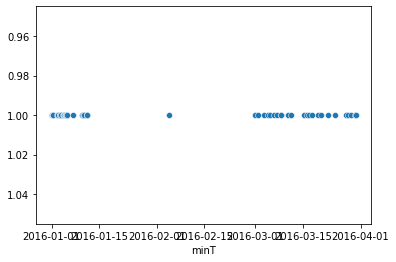

In [41]:
# TSV time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
## CSV time series plots of moriarty
#sns.scatterplot(data=MoriartySessions, x='minT', y=1)
#plt.gca().invert_yaxis()
#plt.show()

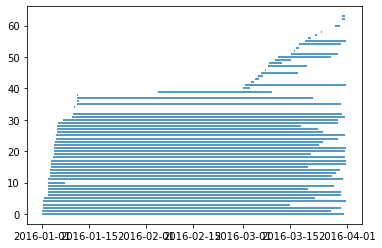

In [42]:
# TSV duration of moriarty
#sns.scatterplot(data=MoriartySessions, x='sessionID', y='Duration')
#plt.gca().invert_yaxis()
#plt.show()
# need to find different x axis, time

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt

fig = plt.figure()
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(MoriartySessions.index, dt.date2num(MoriartySessions.minT), dt.date2num(MoriartySessions.maxT))

In [45]:
## CSV duration of moriarty
#sns.scatterplot(data=MoriartySessions, x='SessionID', y='Duration')
#plt.gca().invert_yaxis()
#plt.show()

In [46]:
# plot intra-session moriarty behavorior

## Feature engineering of Moriarty

In [47]:
# TSV
binary = {'benign': 0, 'malicious': 1}
Moriarty_tsv = Moriarty_tsv.replace({'actionType':binary})
Moriarty_tsv = Moriarty_tsv.replace({'sessionType':binary})
Moriarty_tsv

,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior
494619,fe186dc437,2016-01-01 00:14:34.546,Application entered onCreate(),Application started,0,0,1.0,27,NaN
494625,fe186dc437,2016-01-01 00:14:34.701,User started to play a game (name);pearl,Game stared,0,0,1.0,27,NaN
494620,fe186dc437,2016-01-01 00:14:34.810,App entered onResume,App Mode change,0,0,1.0,27,NaN
494618,fe186dc437,2016-01-01 00:14:40.792,App entered onPause(),App Mode change,0,0,1.0,27,NaN
494622,fe186dc437,2016-01-01 00:14:41.996,User exited from game (name);pearl,Game end,0,0,1.0,27,NaN
...,...,...,...,...,...,...,...,...,...
84849,56d7a3b146,2016-03-31 21:10:41.323,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,2000,NaN
84851,56d7a3b146,2016-03-31 21:10:41.324,Didn't found a new photo(actor);Active-Thief,Reading File(s),1,1,3.0,2000,NaN
84839,56d7a3b146,2016-03-31 21:11:04.602,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN
84834,56d7a3b146,2016-03-31 21:11:23.881,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN


In [48]:
## CSV
#binary = {'benign': 0, 'malicious': 1}
#Moriarty = Moriarty.replace({'ActionType':binary})
#Moriarty = Moriarty.replace({'SessionType':binary})
#Moriarty

### Sensors

In [50]:
#T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
#                           'AccelerometerStat_y_MIDDLE_SAMPLE',
#                           'AccelerometerStat_z_MIDDLE_SAMPLE')
#T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
#                           'MagneticField_y_MIDDLE_SAMPLE',
#                           'MagneticField_z_MIDDLE_SAMPLE')
#T2.head(3)

In [ ]:
# plots of sensors in time...

## Extract Moriarty across datasets

In [56]:
# TSV
print('Bluetooth_tsv.shape ', Bluetooth_tsv.shape)
print('Moriarty_tsv.shape  ', Moriarty_tsv.shape)
print('Screenon_tsv.shape  ', Screenon_tsv.shape)
print('T1_tsv.shape        ', T1_tsv.shape)
print('T4_tsv              ', T4_tsv.shape)
print('Userpresentprobe_tsv',Userpresentprobe_tsv.shape)
#Wifi_tsv  # not loaded yet

print(pd.merge(left=Moriarty_tsv, right=Bluetooth_tsv, left_on='uuid', right_on='uuid').shape)
print(pd.merge(left=Moriarty_tsv, right=Screenon_tsv, left_on='uuid', right_on='uuid').shape)
print(pd.merge(left=Moriarty_tsv, right=T1_tsv, left_on='uuid', right_on='uuid').shape)
print(pd.merge(left=Moriarty_tsv, right=T4_tsv, left_on='uuid', right_on='uuid').shape)
print(pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, left_on='uuid', right_on='uuid').shape)


#print(pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, left_on='uuid', right_on='uuid').shape)

#merged_left = pd.merge(left=Moriarty_tsv, right=Screenon_tsv, how='left', left_on='uuid', right_on='uuid')
#merged_left.tail(200)

Bluetooth_tsv.shape  (657342, 8)
Moriarty_tsv.shape   (513901, 9)
Screenon_tsv.shape   (617639, 4)
T1_tsv.shape         (2697136, 36)
T4_tsv               (2359469, 26)
Userpresentprobe_tsv (169313, 4)
(54, 16)
(50, 12)
(57, 44)
(208, 34)
(11, 12)


### Screen On

In [ ]:
#Moriarty = Moriarty.set_index('UUID')
#ScreenOn = ScreenOn.set_index('UUID')

Merged = ScreenOn.append(Moriarty, sort=True)
#Merged = Merged.sort_index()
Merged = Merged.sort_values(by='UUID')

Merged['ScreenOn'] = Merged['ScreenOn'].fillna(method="pad")
pd.set_option('display.max_rows', 500)
Merged

In [ ]:
filteredMerged = pd.DataFrame()

for index, row in MoriartySessions.iterrows():
    data = Merged[(Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT'])]
    filteredMerged = filteredMerged.append(data, ignore_index=True)
    
filteredMerged[['SessionID', 'SessionType', 'Version']] = filteredMerged[['SessionID', 'SessionType', 'Version']].fillna(method="pad")

In [ ]:
# next steps - integer encode unique - aggregate Success...
filteredMerged['Details'].unique()

In [ ]:
#unit type action type
#malicious vs benigin

In [ ]:
###### predict is screen on from magnitude

In [ ]:
#### predict screen on moriarty...

In [ ]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [ ]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [ ]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [ ]:
print(X_test[0:2].values.tolist())

In [ ]:
#Export as json
import json

data = X_test[0:2].values.tolist()

with open('testdata.json', 'w') as f:
    json.dump(data, f)

### Tests

In [ ]:
from newdata import newdata
newdata

In [ ]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [ ]:
predictions = pipePKL.predict(newdata)
print(predictions)